In [65]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import odeint

%matplotlib inline

In [66]:
"""Constants"""
eps0 = 8.854e-12 #[F/m]
e = 1.60217662e-19 #elementary charge [C]
h = 6.62607004e-34 #Planck's constant [Js]
m_e = 9.10938356e-31 #electron mass [kg]

In [101]:
"""Material dependant constants:"""
'''Fluid'''
fluid_density_list = [0.164, 1.205, 1.98] #He, air, CO2
eta_list = [1.96e-5, 1.81e-5, 1.47e-5] #shear viscosity = kinematic viscosity * denisty of fluid
eps_list = [eps0, 3*eps0, 5*eps0] #permitivity
k_list = [1/(4*math.pi*eps_list[0]), 1/(4*math.pi*eps_list[1]), 1/(4*math.pi*eps_list[2])] 
lp_list = [17.5e-3, 6.7e-3, 4e-3]
pressure = 101.325e3
temp = 298.15
A1_list = [1.277, 1.207, 1.15]

'''QDs'''
#(InAs/GaAs QDs)
Rt = (10*h)/(e**2) #tunneling resistance (made up value)
m_eeff = 0.067 * m_e #electron effective mass [kg]
m_heff = 0.34 * m_e #hole effective mass [kg]
E_g = 0.36 * 1.60217662e-19 #band gap of QD (InAs bulk) [J]


'''Inner section'''
cap_d = 0.394    #capacitance density in [F/m^2] of inner segment capacitors
rho = 3e3 # desity of inner disc material (approxmiate) [kg/m^3]
R_c = 1 #capacitor circuit resistance

In [102]:
"""Initial parameter functions"""
def seperation_angle(n):
    return ( (2*math.pi)/n )

def setup_radius(sep, diam, PHI):
    return ( (sep + diam)/(2 * math.sin(PHI/2)) )

def cog_length( Rp, PHI):
    r = ( Rp*math.sin(PHI) )/(4*math.sin(PHI/2))
    return r

def width( Rp, PHI):
    w = ( Rp*math.sin(PHI) )/2
    return w

def inertia2 (rho, thc, r, w, Rp):
    """Calculates inertia of inner rotating section"""
    m_cog = rho*thc*w*r
    m_disc = math.pi * ((Rp-r)**2)*thc*rho
    I2 = m_cog*((r**2) + (w**2)) + 12*m_cog*((Rp-(r/2))**2) + m_disc*((Rp-r)**2)
    return I2

In [103]:
"""Motor setup functions"""

def permanent_charge_magnitude( r, width, cap_d, cap_vol):
    """Calculates magnitude of total charge stored in inner segment"""
    segment_area = (r/2) * width
    capacitance = cap_d * segment_area #capacitance of one segment
    stored_charge = capacitance * cap_vol #stored charge in one segment
    return stored_charge

def permanent_charges( Rp, p , cap_d, cap_vol, width, r):
    """Initializes permanent charge elements"""
    PCs = {}
    for i in range(p):
        theta = (2*math.pi/p)*i
        xp = Rp*math.cos(theta)
        yp = Rp*math.sin(theta)
        if i%2 == 0:
            p_ch = permanent_charge_magnitude( r, width, cap_d, cap_vol)
        else:
            p_ch = -permanent_charge_magnitude( r, width, cap_d, cap_vol)
        PCs.update({i:[xp,yp,theta, p_ch]}) #dictionary containing all info of permanent charges
    return PCs

def quantum_dots( n, e, noc):
    """Initializes quantum dot elements"""
    QDs = {}
    for i in range(n):
        fi = (2*math.pi/n)*i
        x = R*math.cos(fi)
        y = R*math.sin(fi)
        if i in range(1, n, 4): #will result in +ve torque ==> turning anti-clockwise
            q_ch = noc*e #number of holes stored in quantum dot
        elif i in range(3, n, 4):
            q_ch = -noc*e #number of holes stored in quantum dot
        else:
            q_ch = 0 #neutral quantum dots
        QDs.update({i:[x,y,fi,q_ch]}) #dictionary containing all info on QDs
    return QDs

In [104]:
"""Friction coefficient calculator functions"""

def C(eta0, sigma, Cc):
    coef = (6*math.pi*eta0*sigma)/Cc
    return coef

def Cunningham_correction(A1, lp, pressure, temp, R):
    l = (lp * temp)/(273.15 * pressure) #mean free path
    Kn = l/R #Knudsen number
    Cc = 1 + (A1 * Kn) #only valid for Kn<0.4?
    return Cc    

def  f_t(C, eta0, N, s):
    f = 1/( (1/(N*C)) + ( s/(6*math.pi*(N**2)*eta0) ) )
    return f

def average_inverse_sum( position, N):
    i = 0
    j = 0
    s = 0
    for i in range(N):
        for j in range(N):
            if ( i == j ):
                s += 0
            else:
                r = r_ij(i, j, position)
                s += 1/r
    return s

def positions(Nx, Ny, sigma):
    position = {}
    i = 0
    j = 0
    m = 0
    for j in range(Ny):
        for i in range(Nx):
            x = sigma + 2 * i  * sigma
            y = sigma + 2 * j * sigma
            position.update({m:[x,y]})
            m += 1
    return position

def r_ij(i, j, position):
    distance = math.sqrt( ((position[i][0]-position[j][0])**2) + ((position[i][1]-position[j][1])**2) )
    return distance

def friction_function(eta, thc, width, Cc):
   """Calculates scalar frictional coefficient of one arm"""
    m = 10 #how many times calculation iterates, higher m = higher precision and accuracy but takes longer
    sigma = 5e-9 #starting radius of spheres
    sigmax = sigma/(m+2) #used to store smaller radius of spheres 
    Nx = int(width/(2*sigmax)) #number of spheres in the 'x' direction
    Ny = int(thc/(2*sigmax)) #number of spheres in the 'y' direction
    N = Nx * Ny #total number of spheres
    const = C(eta, sigmax, Cc)
    coord = positions(Nx, Ny, sigmax) #determines the positions of the centers of the spheres
    s = average_inverse_sum(coord, N)
    friction = f_t(const, eta, N, s)
    return (friction) #returns scalar frictional coefficient

IndentationError: unexpected indent (<ipython-input-104-81956f104849>, line 49)

In [105]:
"""Active motor functions"""

def tangential_component(k , n, e, R, Rp, gamma, noc, width, r):
    """Calculates the tangential coulomb force on one inner charge"""
    F_c = 0; #coulomb force
    F_t = 0 #tangential component of coulumb force
    QDs = quantum_dots(n, e, noc) #calls function to initialize QDs
    for i in range(n):
        Q = QDs[i] #dictionary section on ith QD
        ri = math.sqrt(2*R*(R-r0)*(1-math.cos(QDs[i][2]-gamma))+r0**2) #distance between QD and permanent charge edge
        ric = math.sqrt(  ( (Rp-(r/4) )**2) + (R**2) - 2*(Rp-(r/4))*R*math.cos(QDs[i][2]-gamma) ) #distance between QD and permanent charge center
        d = 2*R*math.sin((QDs[i][2]-gamma)/2)
        '''Alpha is alpha at edge of permanent charge'''
        if ((((r0+(r/4))**2)+(ri**2)-(d**2))/(2*(r0+(r/4))*ri)) > 1 or ((((r0+(r/4))**2)+(ri**2)-(d**2))/(2*(r0+(r/4))*ri)) < -1 : #accounts for computational error
            alpha = 0
        else:
            alpha = math.acos((((r0+(r/4))**2)+(ri**2)-(d**2))/(2*(r0+(r/4))*ri)) #angle to tangential in which force vector acts
        if i > n/2:
            alpha = -alpha        
        '''Alphac is alpha at center of permanent charge'''
        if ((((r0+(r/4))**2)+(ric**2)-(d**2))/(2*(r0+(r/4))*ric)) > 1 or ((((r0+(r/4))**2)+(ric**2)-(d**2))/(2*(r0+(r/4))*ric)) < -1 : #accounts for computational error
            alphac = 0
        else:
            alphac = math.acos((((r0+(r/4))**2)+(ric**2)-(d**2))/(2*(r0+(r/4))*ric)) #angle to tangential in which force vector acts
        if i > n/2:
            alphac = -alphac
        ex_minus = ri*math.sin(alpha) - (width/2)
        ex_plus = ri*math.sin(alpha) + (width/2)
        ey_minus = ri*math.cos(alpha)
        ey_plus = ri*math.cos(alpha) + (r/2)
        sigma = PCs[0][3]/(width*r)
        f = force(ex_minus, ex_plus, ey_minus, ey_plus)
        F_c = k*sigma*Q[3]*f #coulomb force between permanent charge and QD
        F_t += F_c*math.sin(alphac)
        #if (n==80):
        #    print (PCs[0][3])
    return F_t

def force( c1, c2, c3, c4):
    a1 = (c4 + math.sqrt((c4**2)+(c1**2)))*(c3 + math.sqrt((c3**2)+(c2**2)))
    b1 = (c4 + math.sqrt((c4**2)+(c2**2)))*(c3 + math.sqrt((c3**2)+(c1**2)))
    a2 = (c2 + math.sqrt((c2**2)+(c3**2)))*(c1 + math.sqrt((c1**2)+(c4**2)))
    b2 = (c2 + math.sqrt((c2**2)+(c4**2)))*(c1 + math.sqrt((c1**2)+(c3**2)))
    I1 = math.log(a1/b1)
    I2 = math.log(a2/b2)
    f = math.sqrt( (I1**2) + (I2**2) )
    return f

def torque (F_t, Rp, p, r):
    """Computes torque on enitre inner rotor"""
    torque_radius = Rp - r/4
    torque = F_t * torque_radius * p
    return torque

def angular_velocity(angle_increment, v_ang, i, torque, inertia):
    """Calculates the angular velocity after rotating the angle increment"""
    w_f = 0
    w_f = math.sqrt( (v_ang[i])**2 + (2*torque*angle_increment)/inertia )
    return w_f

def time_step(inertia, torque, v_ang):
    """Calculates time taken to reach new v_ang"""
    tau = (v_ang[i] - v_ang[i-1])* inertia/torque
    return tau

def Charging_voltage_QD( n, e, Cdot):
    """Constant voltage required to maintain QD charge"""
    QDs = quantum_dots(n,e, noc) #calls function to initialize QDs
    voltage = ( QDs[0][3]/(2*Cdot) ) #voltage needed to add one electron
    return voltage

def QD_capacitance( eps, d):
    Cdot = 2*math.pi*eps*d
    return Cdot

def Capacitor_charging_time( R, C):
    "Computes charging time for capacitors"
    tc = 4 * R * C
    return tc

def Dot_charging_time( Rt, Cdot):
    "Computes charging/discharging time for QDs"
    td = Rt * Cdot
    return td

def Input_energy (n, e, Cdot, Rt, h, m_eeff, diam, E_g, m_heff, noc, cap_vol, R_c):
    """Input power for each step"""
    #for capacitor charging
    E_cC = (PCs[0][3] * cap_vol)
    #for -ve charged dots, energy corresponds to that needed to the required voltage to cause electrons to tunnel into the dot
    E_cQD = (Charging_voltage_QD( n, e, Cdot) * noc * e )
    #for +ve charged dots, energy corresponds to laser energy plus voltage emergy to make electrons tunnel out of the dot
    #laser energy depends on bandgap/energy level seperation
    if (noc % 2 == 0):
        J = noc/2
    else:
        J = (noc + 1)/2
    
    E_l = E_g + ((h**2)*J/(8*m_eeff*(diam**2))) + ((h**2)*J/(8*m_heff*(diam**2)))
    #print( E_cQD )
    #print( E_cC )
    E_intotal = (E_l * (n/4)) + ( (n/2) * (E_cQD + E_cC) )
    return E_intotal

def Output_power(angv, torque):
    return angv * torque

def Output_energy(angv, I):
    E_out = 0.5 * I * (angv**2)
    return E_out

def efficiency(E_in, E_out):
    eff = (E_out/E_in)
    return eff

In [106]:
"""Mathematical functions"""

def func(x, A, B, C, D, E, F, G, H, J, K, L):
    return A * (x**10) + B * (x**9) + C * (x**8)+ D * (x**7) + E * (x**6) + F * (x**5) + G * (x**4) + H * (x**3) + J * (x**2) + K * x + L 

def solvr( Y, t, params):
    const, A, B, C, D, E, F, G, H, J, K, L = params
    return [ Y[1], ( A * (Y[0]**10) + B * (Y[0]**9) + C * (Y[0]**8)+ D * (Y[0]**7) + E * (Y[0]**6) + F * (Y[0]**5) + G * (Y[0]**4) + H * (Y[0]**3) + J * (Y[0]**2) + K * Y[0] + L - const * Y[1]) ]

In [ ]:
'''Test lists'''
N = 201
startN = 12
n_list = []
p_list = []
phi_list = []
R_list = []
Rp_list = []
width_list = []
r_list = []
I_list = []
step_list = []
angle_increment_list = []
Abig_list = []
Bbig_list = []
Cbig_list = []
Dbig_list = []
Ebig_list = []
Fbig_list = []
Gbig_list = []
Hbig_list = []
Jbig_list = []
Kbig_list = []
Lbig_list = []
A_list = []
B_list = []
C_list = []
D_list = []
E_list = []
F_list = []
G_list = []
H_list = []
J_list = []
K_list = []
L_list = []
color_list = ['b', 'g', 'r', 'c', 'm', 'y']

'''QDs'''
diam = 10e-9 #diameter of QDs [m]
sep = 130e-9 #seperation of QDs [m] (corresponds to motor dead zone)
noc = 6 #number of charge carriers contributing to net charge of QD
'''Inner section'''
r0 = 110e-9
thc = 30e-9   #approximate thickeness of inner disc [m]
cap_vol = 2   #applied voltage to capacitors in inner disck ("permanent charges"/charged segments) [V]
i=0
material_constant_list = []
for element in fluid_density_list:
    j=0
    constant_list = []
    for n in np.arange(startN, N, 4):
        PHI = seperation_angle(n) #angle of seperation between QDs
        phi_list.append(PHI)
        R = setup_radius(sep, diam, PHI)  #radius of QD setup [m] 5.36290830288e-07
        R_list.append(R)
        Rp = R - r0   #radius of rotating disc [m]
        Rp_list.append(Rp)
        w = width( Rp, PHI ) #cog "tooth"/capacitor arm width [m]
        width_list.append(w)
        r = cog_length( Rp, PHI)    #length of the cog shaft [m]
        r_list.append(r)
        I = inertia2 (rho, thc, r, w, Rp) #inertia of inner rotating disk
        I_list.append(I)
        p = int(n/2)
        p_list.append(p)
        n_list.append(n)
        Cc = Cunningham_correction(A1_list[i], lp_list[i], pressure, temp, R_list[j])
        cof = friction_function(eta_list[i], thc, width_list[j], Cc)
        constant_list.append(p_list[j] * cof)  #coefficient of drag force function
        step = math.pi*(360/n)/180 #angle between each QD, angle required for one step
        step_list.append(step)
        angle_increment = step/100
        angle_increment_list.append( angle_increment )
        print (n)
        j+=1
    material_constant_list.append(constant_list)
    i +=1

12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116
120
124
128
132
136
140
144
148
152
156
160
164
168
172
176
180
184
188
192


In [75]:
i=0
Tbig_list = []
for element in fluid_density_list:
    j=0
    T_list = []
    for n in np.arange(startN, N, 4):
        PCs = permanent_charges( Rp_list[j], p_list[j] , cap_d, cap_vol, width_list[j], r_list[j]) #initializes permanent charges
        #if (n==80):
        #    print (Rp_list[j], p_list[j] , cap_d, cap_vol, width_list[j], r_list[j] )
        T = []
        gamma_list = []
        for gamma in np.arange(0, step_list[j], angle_increment_list[j]): #iterates angle increment until one step is completed
            gamma_list.append( gamma )
            F_t = tangential_component(k_list[i] , n_list[j], e, R_list[j], Rp_list[j], gamma, noc, width_list[j], r_list[j])
            T.append( torque(F_t, Rp_list[j], p_list[j], r_list[j]) ) #calculates torque acting on inner rotor
        T_list.append( T )
        popt, pcov = curve_fit(func, gamma_list, T)
        A_list.append(popt[0])
        B_list.append(popt[1])
        C_list.append(popt[2])
        D_list.append(popt[3])
        E_list.append(popt[4])
        F_list.append(popt[5])
        G_list.append(popt[6])
        H_list.append(popt[7])
        J_list.append(popt[8])
        K_list.append(popt[9])
        L_list.append(popt[10])
        j+=1
        print (n)
    Tbig_list.append( T_list )
    Abig_list.append(A_list)
    Bbig_list.append(B_list)
    Cbig_list.append(C_list)
    Dbig_list.append(D_list)
    Ebig_list.append(E_list)
    Fbig_list.append(F_list)
    Gbig_list.append(G_list)
    Hbig_list.append(H_list)
    Jbig_list.append(J_list)
    Kbig_list.append(K_list)
    Lbig_list.append(L_list)
    i+=1
plt.show()

12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116
120
124
128
132
136
140
144
148
152
156
160
164
168
172
176
180
184
188
192
196
200
12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116
120
124
128
132
136
140
144
148
152
156
160
164
168
172
176
180
184
188
192
196
200
12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116
120
124
128
132
136
140
144
148
152
156
160
164
168
172
176
180
184
188
192
196
200


C:\Users\Pauli\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


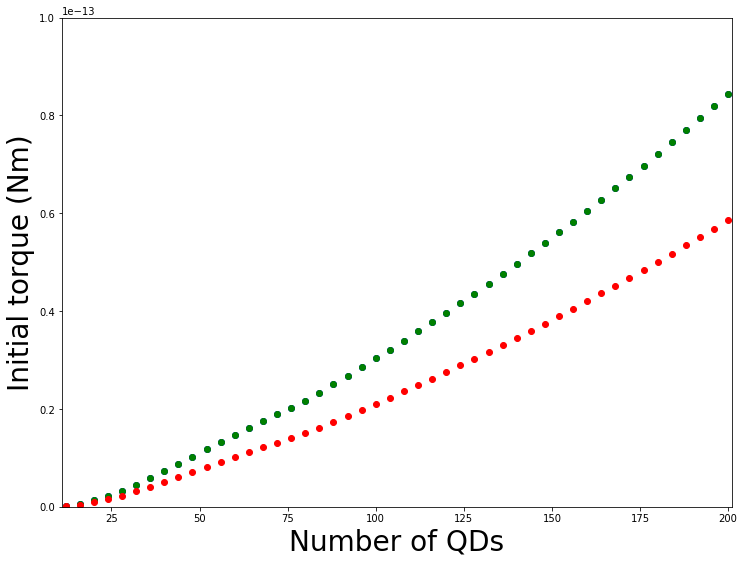

In [91]:
fig2 = plt.figure(figsize=(12, 9))
bx1 = fig2.add_subplot(111)
bx1.set_xlabel('Number of QDs', fontsize ='28')
bx1.set_ylabel('Initial torque (Nm)', fontsize ='28')
bx1.set_ylim( 0 , 1e-13 )
bx1.set_xlim( startN-1 , N )
bx2 = fig2.add_subplot(111)
bx3 = fig2.add_subplot(111)
bx_list = [bx1, bx2, bx3]

i=0
tor = []
for element in fluid_density_list:
    j=0
    tor = Tbig_list[i]
    for n in np.arange(startN, N, 4):
        tor2 = tor[j]
        bx_list[i].scatter(n, tor2[0] , color = color_list[i])
        j+=1
    i+=1

In [77]:
tor = Tbig_list[0]
tor2 = tor[17]
print (tor2[0])

2.1643298277970314e-14


In [78]:
i=0
snipped_solbig_list = []
for element in fluid_density_list:
    snipped_sol_list = []
    keep_j_list = []
    constant_list = []
    constant_list = material_constant_list[i]
    A_list = []
    B_list = []
    C_list = []
    D_list = []
    E_list = []
    F_list = []
    G_list = []
    H_list = []
    J_list = []
    K_list = []
    L_list = []
    A_list = Abig_list[i]
    B_list = Bbig_list[i]
    C_list = Cbig_list[i]
    D_list = Dbig_list[i]
    E_list = Ebig_list[i]
    F_list = Fbig_list[i]
    G_list = Gbig_list[i]
    H_list = Hbig_list[i]
    J_list = Jbig_list[i]
    K_list = Kbig_list[i]
    L_list = Lbig_list[i]
    j=0
    for n in np.arange(startN, N, 4):
        params = [ ( (constant_list[j]*(Rp_list[j]-(r_list[j]/4))/2)/(I_list[j]) ) , ( A_list[j]/(I_list[j]) ), ( B_list[j]/(I_list[j]) ), ( C_list[j]/(I_list[j]) ), (D_list[j]/(I_list[j]) ), ( E_list[j]/(I_list[j]) ), ( F_list[j]/(I_list[j]) ), ( G_list[j]/(I_list[j]) ), ( H_list[j]/(I_list[j]) ), ( J_list[j]/(I_list[j]) ), ( K_list[j]/(I_list[j]) ), (L_list[j]/(I_list[j]) ) ]
        tStop = 3
        tInc = 1e-5
        t_array = np.arange( 0, tStop, tInc)
        sol = odeint( solvr, [0,0], t_array, args=(params,) )
        keep_j = 0
        for z in np.arange( 0, len(t_array) ):
            if sol[z][0] >= step_list[j]:
                keep_j = z
                break
            else:
                keep_j = len(t_array)
        keep_j_list.append( keep_j )
        snipped_sol = np.zeros((keep_j, 2))
        snipped_sol = sol[:keep_j]
        snipped_sol_list.append( snipped_sol )
        j+=1
        print(n)
        print (len(t_array))
        print (keep_j)
    snipped_solbig_list.append( snipped_sol_list )
    i+=1

12
300000
300000


C:\Users\Pauli\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


16
300000
300000
20
300000
812
24
300000
300000
28
300000
300000
32
300000
300000
36
300000
384
40
300000
328
44
300000
341
48
300000
300000
52
300000
300000
56
300000
300000
60
300000
262
64
300000
263
68
300000
300000
72
300000
300000
76
300000
272
80
300000
271
84
300000
300000
88
300000
300000
92
300000
251
96
300000
220
100
300000
239
104
300000
300000
108
300000
300000
112
300000
300000
116
300000
220
120
300000
201
124
300000
205
128
300000
300000
132
300000
300000
136
300000
300000
140
300000
300000
144
300000
199
148
300000
190
152
300000
216
156
300000
300000
160
300000
300000
164
300000
207
168
300000
194
172
300000
300000
176
300000
300000
180
300000
300000
184
300000
178
188
300000
165
192
300000
205
196
300000
300000
200
300000
300000
12
300000
300000
16
300000
1254
20
300000
754
24
300000
300000
28
300000
300000
32
300000
300000
36
300000
355
40
300000
304
44
300000
316
48
300000
300000
52
300000
300000
56
300000
300000
60
300000
243
64
300000
243
68
300000
300000
72
300

In [79]:
i=0
E_OUTbig_list = []
for element in fluid_density_list:
    snipped_sol_list = snipped_solbig_list[i]
    E_OUT_list = []
    A_list = []
    B_list = []
    C_list = []
    D_list = []
    E_list = []
    F_list = []
    G_list = []
    H_list = []
    J_list = []
    K_list = []
    L_list = []
    A_list = Abig_list[i]
    B_list = Bbig_list[i]
    C_list = Cbig_list[i]
    D_list = Dbig_list[i]
    E_list = Ebig_list[i]
    F_list = Fbig_list[i]
    G_list = Gbig_list[i]
    H_list = Hbig_list[i]
    J_list = Jbig_list[i]
    K_list = Kbig_list[i]
    L_list = Lbig_list[i]
    j=0
    for n in np.arange(startN, N, 4):
        snip_sol = snipped_sol_list[j]
        E_OUT = 0
        for z in np.arange( 0, len(snip_sol) ):
            p_out = Output_power(snip_sol[z][1], func(snip_sol[z][0], A_list[j], B_list[j], C_list[j], D_list[j], E_list[j], F_list[j], G_list[j], H_list[j], J_list[j], K_list[j], L_list[j]) )
            E_OUT += p_out * tInc
        E_OUT_list.append( E_OUT )
        j+=1
        #print (n  ,  E_OUT)
    E_OUTbig_list.append( E_OUT_list )
    i+=1

In [80]:
"""Computes input power"""
Cdot = QD_capacitance( eps0, diam)
E_in_list = []
i=0
for n in np.arange(startN, N, 4):
    PCs = permanent_charges( Rp_list[i], p_list[i] , cap_d, cap_vol, width_list[i], r_list[i])
    E_in = Input_energy (n_list[i], e, Cdot, Rt, h, m_eeff, diam, E_g, m_heff, noc, cap_vol, R_c)
    E_in_list.append( E_in )
    i+=1


C:\Users\Pauli\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


12 0.494159132496
16 0.447703232052
20 0.39511918603
24 0.344570212082
28 0.300032008353
32 0.261642501768
36 0.228876943155
40 0.200943717997
44 0.177117368808
48 0.156788431316
52 0.139390454846
56 0.124440813064
60 0.111582231455
64 0.100459669168
68 0.0908118984522
72 0.0824268750244
76 0.0751038879682
80 0.0686753940144
84 0.063005610541
88 0.0580179424558
92 0.0536021221326
96 0.0496841495237
100 0.0461978112305
104 0.0430886810196
108 0.0403077644924
112 0.0378141732308
116 0.0355700442412
120 0.0335500792199
124 0.0317187911474
128 0.0300585648526
132 0.028550269852
136 0.0271767631607
140 0.0259228758085
144 0.0247751557305
148 0.02372187972
152 0.02275324299
156 0.0218610641544
160 0.0210378899297
164 0.0202767587352
168 0.0195708463214
172 0.0189150812423
176 0.0183027386866
180 0.0177149927391
184 0.0171535054962
188 0.0166159890946
192 0.016100599706
196 0.0156061790306
200 0.0151316892894
12 0.494101638856
16 0.448905275523
20 0.394991888759
24 0.344423616393
28 0.2998750

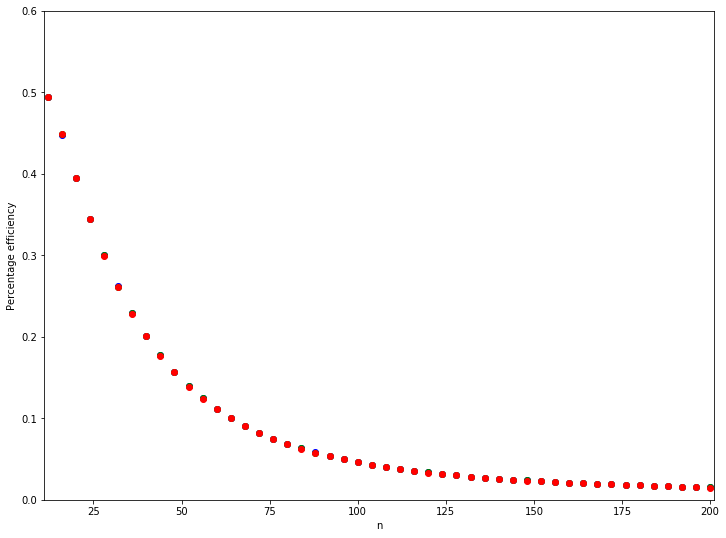

In [81]:
fig1 = plt.figure(figsize=(12, 9))
ax1 = fig1.add_subplot(111)
ax1.set_xlabel('Number of QDs', fontsize ='28')
ax1.set_ylabel('Percentage efficiency', fontsize ='28')
ax1.set_ylim( 0 , 0.6 )
ax1.set_xlim( startN-1 , N )
ax2 = fig1.add_subplot(111)
ax3 = fig1.add_subplot(111)
ax_list = [ax1, ax2, ax3]

i=0
for element in fluid_density_list:
    E_OUT_list = E_OUTbig_list[i]
    eff_percent_list = []
    j=0
    for n in np.arange(startN, N, 4):
        eff = efficiency( E_in_list[j], E_OUT_list[j] )
        print ( n, eff*100 )
        eff_percent_list.append( eff*100 )
        ax_list[i].scatter( n_list[j], eff_percent_list[j], color= color_list[i] )
        j+=1
    i+=1

In [82]:
i=0
for element in E_in_list:
    print ( E_in_list[i] )
    i+=1

1.46983521822e-14
3.66187343448e-14
6.84772253154e-14
1.10236744045e-13
1.6187369958e-13
2.2337374845e-13
2.94727917422e-13
3.75930372833e-13
4.66977180713e-13
5.67865600626e-13
6.78593668827e-13
7.99159943146e-13
9.2956334154e-13
1.06980303679e-12
1.21987838593e-12
1.37978888182e-12
1.5495341192e-12
1.72911377035e-12
1.91852756748e-12
2.1177752896e-12
2.32685675279e-12
2.54577180274e-12
2.77452030901e-12
3.01310216061e-12
3.26151726252e-12
3.51976553289e-12
3.78784690085e-12
4.06576130475e-12
4.35350869069e-12
4.65108901133e-12
4.95850222494e-12
5.2757482946e-12
5.6028271875e-12
5.93973887441e-12
6.28648332919e-12
6.64306052839e-12
7.00947045094e-12
7.38571307781e-12
7.77178839181e-12
8.16769637736e-12
8.57343702028e-12
8.9890103077e-12
9.41441622783e-12
9.84965476992e-12
1.02947259241e-11
1.07496296813e-11
1.12143660333e-11
1.16889349723e-11


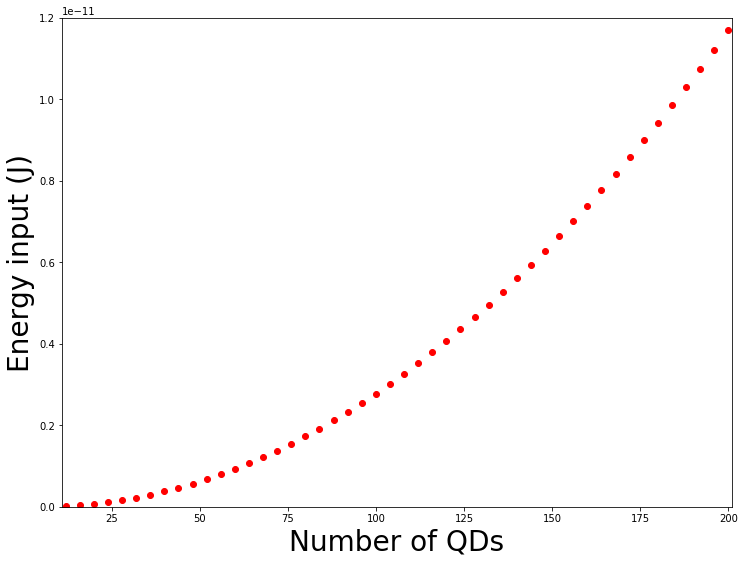

In [93]:
fig2 = plt.figure(figsize=(12, 9))
cx1 = fig2.add_subplot(111)
cx1.set_xlabel('Number of QDs', fontsize ='28')
cx1.set_ylabel('Energy input (J)', fontsize ='28')
cx1.set_ylim( 0 , 1.2e-11 )
cx1.set_xlim( startN-1 , N )
#cx2 = fig1.add_subplot(111)
#cx3 = fig1.add_subplot(111)
#cx_list = [ax1, ax2, ax3]

i=0
for n in np.arange(startN, N, 4):
    cx1.scatter( n_list[i], E_in_list[i], color = 'r' )
    i+=1

In [84]:
i=0
for element in fluid_density_list:
    j=0
    E_OUT_list = E_OUTbig_list[i]
    for n in np.arange(startN, N, 4):
        print ( E_OUT_list[j] )
        j+=1
    print ("fuck hayfever")
    i+=1

7.26332496348e-17
1.63943257199e-16
2.70566655282e-16
3.79842982748e-16
4.85672911846e-16
5.84440663738e-16
6.74564248021e-16
7.55408468251e-16
8.27097695412e-16
8.90347567203e-16
9.45894801533e-16
9.94481130929e-16
1.03722751928e-15
1.07472059151e-15
1.10779472107e-15
1.13731685722e-15
1.16376036891e-15
1.18747569475e-15
1.20878000729e-15
1.22868964886e-15
1.24724459848e-15
1.264845069e-15
1.28176765491e-15
1.29830597878e-15
1.31464469705e-15
1.33097023592e-15
1.34733881842e-15
1.36406613864e-15
1.38088032918e-15
1.39805060682e-15
1.41566576584e-15
1.43377761898e-15
1.45241393358e-15
1.47157955612e-15
1.49127201397e-15
1.511511704e-15
1.53234483216e-15
1.55379818783e-15
1.57586678162e-15
1.59848730601e-15
1.62167257764e-15
1.64523506713e-15
1.66776315119e-15
1.68956107232e-15
1.71057053687e-15
1.73075484487e-15
1.7501340403e-15
1.76873332124e-15
fuck hayfever
7.26247990172e-17
1.64383430304e-16
2.70479485643e-16
3.79681380433e-16
4.85418835572e-16
5.84081551e-16
6.74101047329e-16
7.54

C:\Users\Pauli\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


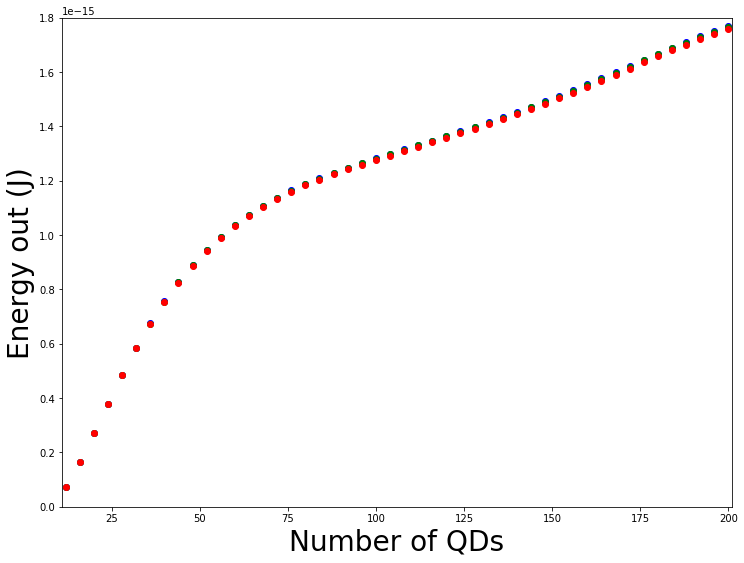

In [94]:
fig3 = plt.figure(figsize=(12, 9))
dx1 = fig3.add_subplot(111)
dx1.set_xlabel('Number of QDs', fontsize ='28')
dx1.set_ylabel('Energy out (J)', fontsize ='28')
dx1.set_ylim( 0 , 1.8e-15 )
dx1.set_xlim( startN-1 , N )
dx2 = fig3.add_subplot(111)
dx3 = fig3.add_subplot(111)
dx_list = [dx1, dx2, dx3]

i=0
for element in fluid_density_list:
    j=0
    E_OUT_list = E_OUTbig_list[i]
    for n in np.arange(startN, N, 4):
        dx_list[i].scatter( n_list[j], E_OUT_list[j], color = color_list[i] )
        j+=1
    i+=1

In [86]:
i=0
for element in fluid_density_list:
    snipped_sol_list = snipped_solbig_list[i]
    j=0
    for n in np.arange(startN, N, 4):
        snip_sol = snipped_sol_list[j]
        maxw = np.max(snip_sol[1])
        print (n , maxw)
        j+=1
    i+=1

12 115.184427334
16 153.70571094
20 176.56893547
24 190.606130514
28 198.025713342
32 201.450864384
36 198.747221477
40 195.214387429
44 191.590888764
48 184.770436292
52 177.118953132
56 170.673675518
60 162.547858345
64 155.979971096
68 149.345439337
72 141.357143532
76 135.137361387
80 130.225505275
84 126.709649324
88 122.598927173
92 119.660296544
96 116.740000034
100 113.98165621
104 111.453062459
108 109.127597832
112 106.909714503
116 104.75952394
120 101.761853854
124 99.7964407811
128 97.9688339585
132 96.2797311204
136 94.6957483033
140 93.1734772596
144 91.6895033756
148 90.2538428148
152 88.8954241055
156 87.6305514822
160 86.4386085712
164 85.2778511101
168 84.1439918235
172 83.0783923223
176 81.3391493168
180 80.3473841859
184 79.4000922257
188 78.5132267325
192 77.6502589643
196 76.7961855574
200 75.9557493404
12 123.321582525
16 165.120517042
20 190.033150237
24 205.374297888
28 213.529582602
32 217.336804839
36 214.516138165
40 210.781395781
44 206.92805905
48 199.603

C:\Users\Pauli\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


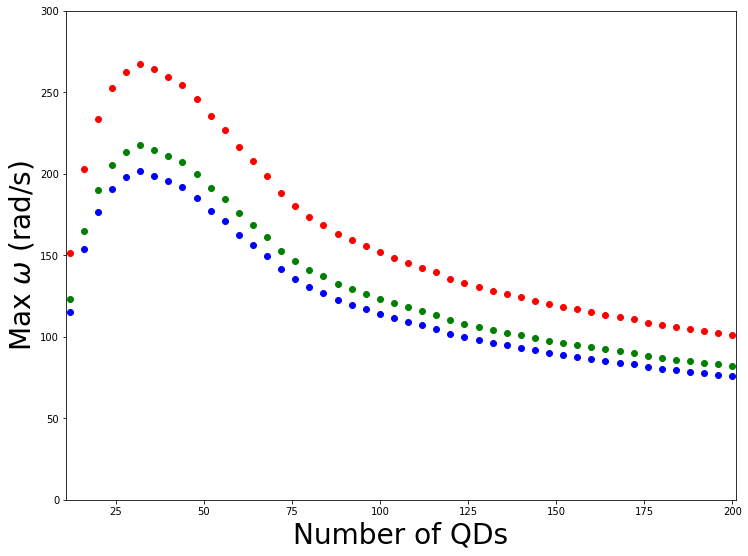

In [98]:
fig4 = plt.figure(figsize=(12, 9))
ex1 = fig4.add_subplot(111)
ex1.set_xlabel('Number of QDs', fontsize ='28')
ex1.set_ylabel('Max $\omega$ (rad/s)', fontsize ='28')
ex1.set_ylim( 0 , 300)
ex1.set_xlim( startN-1 , N )
ex2 = fig4.add_subplot(111)
ex3 = fig4.add_subplot(111)
ex_list = [ex1, ex2, ex3]
i=0
for element in fluid_density_list:
    snipped_sol_list = snipped_solbig_list[i]
    j=0
    for n in np.arange(startN, N, 4):
        snip_sol = snipped_sol_list[j]
        maxw = np.max(snip_sol[1])
        ex_list[i].scatter( n_list[j], maxw, color = color_list[i] )
        j+=1
    i+=1

C:\Users\Pauli\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


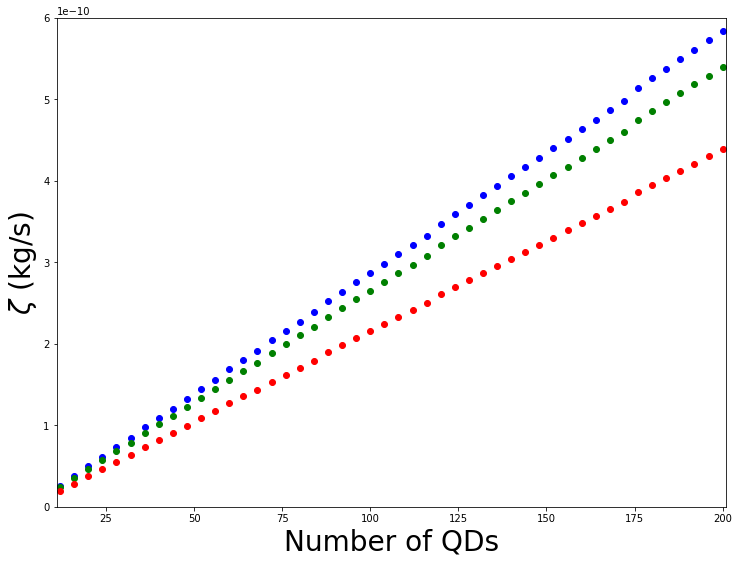

In [97]:
fig5 = plt.figure(figsize=(12, 9))
fx1 = fig5.add_subplot(111)
fx1.set_xlabel('Number of QDs', fontsize ='28')
fx1.set_ylabel('$\zeta$ (kg/s)', fontsize ='28')
fx1.set_ylim( 0 , 0.6e-9)
fx1.set_xlim( startN-1 , N )
fx2 = fig5.add_subplot(111)
fx3 = fig5.add_subplot(111)
fx_list = [fx1, fx2, fx3]
i=0
for element in fluid_density_list:
    const = material_constant_list[i]
    j=0
    for n in np.arange(startN, N, 4):
        constant = const[j]
        fx_list[i].scatter( n_list[j], constant, color = color_list[i] )
        j+=1
    i+=1

C:\Users\Pauli\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


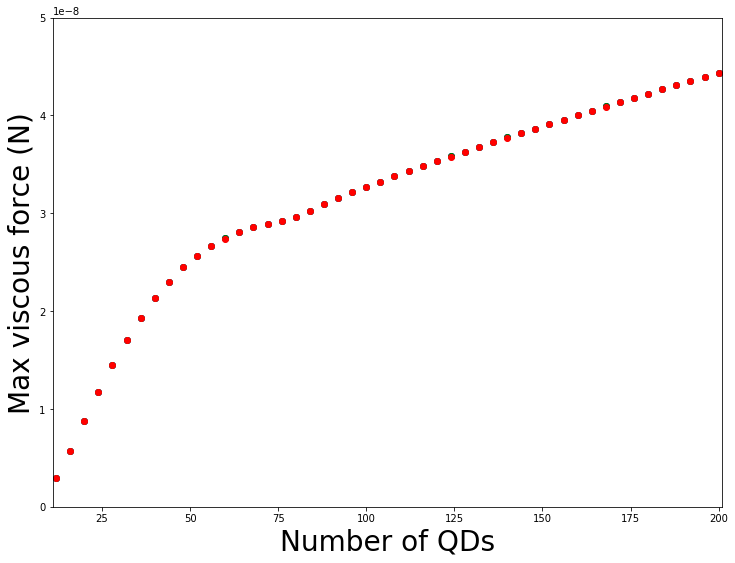

In [100]:
fig6 = plt.figure(figsize=(12, 9))
gx1 = fig6.add_subplot(111)
gx1.set_xlabel('Number of QDs', fontsize ='28')
gx1.set_ylabel('Max viscous force (N)', fontsize ='28')
gx1.set_ylim( 0 , 5e-8)
gx1.set_xlim( startN-1 , N )
gx2 = fig6.add_subplot(111)
gx3 = fig6.add_subplot(111)
gx_list = [gx1, gx2, gx3]
i=0
for element in fluid_density_list:
    const = material_constant_list[i]
    snipped_sol_list = snipped_solbig_list[i]
    j=0
    for n in np.arange(startN, N, 4):
        constant = const[j]
        snip_sol = snipped_sol_list[j]
        maxw = np.max(snip_sol[1])
        #print (constant*maxw)
        gx_list[i].scatter( n_list[j], constant*maxw , color = color_list[i] )
        j+=1
    i+=1